In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import torch
import numpy as np
from tqdm import tqdm
import sys

sys.path.append("../../src")
from src.explainer import Archipelago
from synthetic_utils import *

sys.path.append("../../baselines")
from baselines.shapley_interaction_index.si_explainer import SiExplainer

from baselines.shapley_taylor_interaction_index.sti_explainer import StiExplainer, subset_before

# from baselines.mahe_madex.madex.utils import general_utils as nid_utils
# import baselines.mahe_madex.madex.neural_interaction_detection as nid

import statsmodels.api as sm
from statsmodels.formula.api import ols


## Parameters

In [3]:
method = "si"
function_id = 4
print('method ', method)
p = 40 # num features
input_value, base_value = 1, -1

method  si


## Get Data and Synthetic Function

In [4]:
input = np.array([input_value]*p)
baseline = np.array([base_value]*p)

print("function id:", function_id)
model = synth_model(function_id, input_value, base_value)
gts = model.get_gts(p)

function id: 4


## Run Baseline Method

In [5]:
if method == "archdetect":
    apgo = Archipelago(model, input=input, baseline=baseline, output_indices=0, batch_size=20) 
    inter_scores = apgo.archdetect()["interactions"]
    
elif method == "si":
    si_method = SiExplainer(model, input=input, baseline=baseline, output_indices=0, batch_size=20, seed=42)

    num_T = 20
    inter_scores = []
    for i in range(p):
        for j in range(i+1, p):
            S = (i,j)
            att = si_method.attribution(S, num_T)
            inter_scores.append( (S, att**2))

elif method == "sti":
    sti_method = StiExplainer(model, input=input, baseline=baseline, output_indices=0, batch_size=20)
    
    inter_atts = sti_method.batch_attribution(num_orderings=20, pairwise=True, seed=42)
    inter_scores = []
    for i in range(p):
        for j in range(i+1, p):
            inter_scores.append( ( (i,j), inter_atts[i,j]**2) )
            
# elif method == "nid":
#     X, Y = gen_data_samples(model, input_value, base_value, p, n=30000, seed=42)
#     Xs, Ys = nid_utils.proprocess_data(X, Y, valid_size = 10000, test_size=10000, std_scale_X=True, std_scale=True)
#     inter_scores, mlp_loss = nid.detect_interactions(Xs, Ys, pairwise=True, seed=42)
#
# elif method == "anova":
#     X, Y = gen_data_samples(model, input_value, base_value, p, n=30000, seed=42)
#     Xs, Ys = nid_utils.proprocess_data(X, Y, valid_size = 10000, test_size=10000, std_scale_X=True, std_scale=True)
#     X_train = Xs["train"]
#     Y_train = Ys["train"]
    
    data =  {}
    data['y'] = Y_train.squeeze()
    st =''
    for i in range(0,X_train.shape[1]):    
        data['X'+str(i)] = X_train[:,i]
        st+='+X'+str(i)
    st = "("+st[1:]+")"
    formula = 'y ~ '+st+":"+st

    lm = ols(formula,data=data).fit()

    table = sm.stats.anova_lm(lm, typ=2)
    inter_scores = []
    for i, name in enumerate(table.index):
        if name == "Residual": continue
        inter = tuple(int(x) for x in name.replace("X", "").split(":"))
        if len(inter)==1: continue

        inter_scores.append((inter, table.values[i,0]))

In [6]:
if method == "archdetect":
    apgo = Archipelago(model, input=input, baseline=baseline, output_indices=0, batch_size=20) 
    inter_scores = apgo.archdetect()["interactions"]
    
elif method == "si":
    si_method = SiExplainer(model, input=input, baseline=baseline, output_indices=0, batch_size=20, seed=42)

    num_T = 20
    inter_scores = []
    for i in range(p):
        for j in range(i+1, p):
            S = (i,j)
            att = si_method.attribution(S, num_T)
            inter_scores.append( (S, att**2))

elif method == "sti":
    sti_method = StiExplainer(model, input=input, baseline=baseline, output_indices=0, batch_size=20)
    
    inter_atts = sti_method.batch_attribution(num_orderings=20, pairwise=True, seed=42)
    inter_scores = []
    for i in range(p):
        for j in range(i+1, p):
            inter_scores.append( ( (i,j), inter_atts[i,j]**2) )
            
elif method == "nid":
    X, Y = gen_data_samples(model, input_value, base_value, p, n=30000, seed=42)
    Xs, Ys = nid_utils.proprocess_data(X, Y, valid_size = 10000, test_size=10000, std_scale_X=True, std_scale=True)
    inter_scores, mlp_loss = nid.detect_interactions(Xs, Ys, pairwise=True, seed=42)

elif method == "anova":
    X, Y = gen_data_samples(model, input_value, base_value, p, n=30000, seed=42)
    Xs, Ys = nid_utils.proprocess_data(X, Y, valid_size = 10000, test_size=10000, std_scale_X=True, std_scale=True)
    X_train = Xs["train"]
    Y_train = Ys["train"]
    
    data =  {}
    data['y'] = Y_train.squeeze()
    st =''
    for i in range(0,X_train.shape[1]):    
        data['X'+str(i)] = X_train[:,i]
        st+='+X'+str(i)
    st = "("+st[1:]+")"
    formula = 'y ~ '+st+":"+st

    lm = ols(formula,data=data).fit()

    table = sm.stats.anova_lm(lm, typ=2)
    inter_scores = []
    for i, name in enumerate(table.index):
        if name == "Residual": continue
        inter = tuple(int(x) for x in name.replace("X", "").split(":"))
        if len(inter)==1: continue

        inter_scores.append((inter, table.values[i,0]))

In [7]:
gts

[(0, 1),
 (0, 2),
 (1, 2),
 (10, 11),
 (10, 12),
 (10, 13),
 (10, 14),
 (10, 15),
 (10, 16),
 (10, 17),
 (10, 18),
 (10, 19),
 (10, 20),
 (10, 21),
 (10, 22),
 (10, 23),
 (10, 24),
 (10, 25),
 (10, 26),
 (10, 27),
 (10, 28),
 (10, 29),
 (11, 12),
 (11, 13),
 (11, 14),
 (11, 15),
 (11, 16),
 (11, 17),
 (11, 18),
 (11, 19),
 (11, 20),
 (11, 21),
 (11, 22),
 (11, 23),
 (11, 24),
 (11, 25),
 (11, 26),
 (11, 27),
 (11, 28),
 (11, 29),
 (12, 13),
 (12, 14),
 (12, 15),
 (12, 16),
 (12, 17),
 (12, 18),
 (12, 19),
 (12, 20),
 (12, 21),
 (12, 22),
 (12, 23),
 (12, 24),
 (12, 25),
 (12, 26),
 (12, 27),
 (12, 28),
 (12, 29),
 (13, 14),
 (13, 15),
 (13, 16),
 (13, 17),
 (13, 18),
 (13, 19),
 (13, 20),
 (13, 21),
 (13, 22),
 (13, 23),
 (13, 24),
 (13, 25),
 (13, 26),
 (13, 27),
 (13, 28),
 (13, 29),
 (14, 15),
 (14, 16),
 (14, 17),
 (14, 18),
 (14, 19),
 (14, 20),
 (14, 21),
 (14, 22),
 (14, 23),
 (14, 24),
 (14, 25),
 (14, 26),
 (14, 27),
 (14, 28),
 (14, 29),
 (15, 16),
 (15, 17),
 (15, 18),
 (15,

In [8]:
inter_scores

[((0, 1), 9.354701760754304e-22),
 ((0, 2), 2.1650304374272043e-21),
 ((0, 3), 0.0),
 ((0, 4), 0.0),
 ((0, 5), 0.0),
 ((0, 6), 0.0),
 ((0, 7), 0.0),
 ((0, 8), 0.0),
 ((0, 9), 0.0),
 ((0, 10), 0.0),
 ((0, 11), 0.0),
 ((0, 12), 0.0),
 ((0, 13), 0.0),
 ((0, 14), 0.0),
 ((0, 15), 0.0),
 ((0, 16), 0.0),
 ((0, 17), 0.0),
 ((0, 18), 0.0),
 ((0, 19), 0.0),
 ((0, 20), 0.0),
 ((0, 21), 0.0),
 ((0, 22), 0.0),
 ((0, 23), 0.0),
 ((0, 24), 0.0),
 ((0, 25), 0.0),
 ((0, 26), 0.0),
 ((0, 27), 0.0),
 ((0, 28), 0.0),
 ((0, 29), 0.0),
 ((0, 30), 0.0),
 ((0, 31), 0.0),
 ((0, 32), 0.0),
 ((0, 33), 0.0),
 ((0, 34), 0.0),
 ((0, 35), 0.0),
 ((0, 36), 0.0),
 ((0, 37), 0.0),
 ((0, 38), 0.0),
 ((0, 39), 0.0),
 ((1, 2), 9.594123408513062e-22),
 ((1, 3), 0.0),
 ((1, 4), 0.0),
 ((1, 5), 0.0),
 ((1, 6), 0.0),
 ((1, 7), 0.0),
 ((1, 8), 0.0),
 ((1, 9), 0.0),
 ((1, 10), 0.0),
 ((1, 11), 0.0),
 ((1, 12), 0.0),
 ((1, 13), 0.0),
 ((1, 14), 0.0),
 ((1, 15), 0.0),
 ((1, 16), 0.0),
 ((1, 17), 0.0),
 ((1, 18), 0.0),
 ((1, 19),

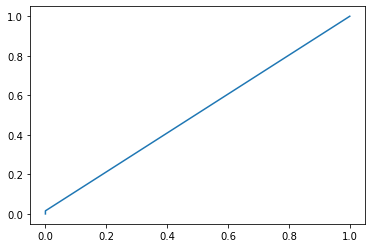

auc 0.5077720207253886


In [10]:
print("auc", get_auc(inter_scores, gts))